In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

import blackjax

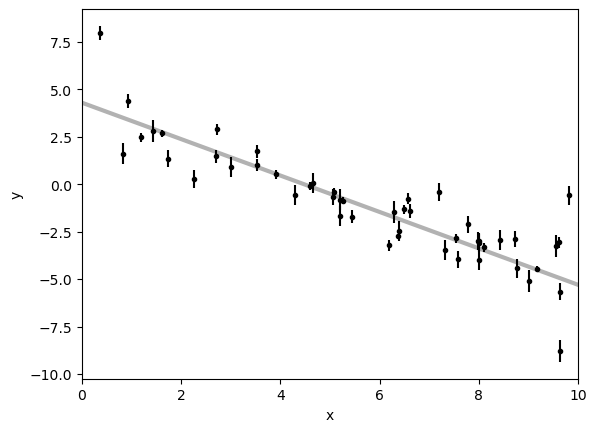

In [2]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [3]:
def log_likelihood(m, b, log_f, x=x, y=y, yerr=yerr):
    model = m * x + b
    sigma2 = yerr**2 + model**2 * jnp.exp(2 * log_f)
    print(type(-0.5 * jnp.sum((y - model) ** 2 / sigma2 + jnp.log(sigma2))))
    return -0.5 * jnp.sum((y - model) ** 2 / sigma2 + jnp.log(sigma2))

def log_probability(m, b, log_f, x=x, y=y, yerr=yerr):
    return log_likelihood(m, b, log_f, x, y, yerr)

logdensity = lambda a: log_probability(**a)

In [4]:
inv_mass_matrix = np.array([0.01, 0.01, 0.01])
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

In [5]:
initial_position = {"m": -1.0, "b": 5.0, "log_f": jnp.log(0.5)}
initial_state = hmc.init(initial_position)
initial_state

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<class 'jax._src.interpreters.ad.JVPTracer'>


HMCState(position={'m': -1.0, 'b': 5.0, 'log_f': Array(-0.6931472, dtype=float32, weak_type=True)}, logdensity=Array(-44.265114, dtype=float32), logdensity_grad={'b': Array(-79.052475, dtype=float32, weak_type=True), 'log_f': Array(5.0321994, dtype=float32, weak_type=True), 'm': Array(-402.75284, dtype=float32, weak_type=True)})

In [6]:
hmc_kernel = jax.jit(hmc.step)

In [7]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [8]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, hmc_kernel, initial_state, 10_000)

m_samples = states.position["m"].block_until_ready()
b_samples = states.position["b"].block_until_ready()
#scale_samples = jnp.exp(states.position["log_scale"])

<class 'jax._src.interpreters.ad.JVPTracer'>
CPU times: user 824 ms, sys: 12.9 ms, total: 837 ms
Wall time: 830 ms


Text(0, 0.5, 'b')

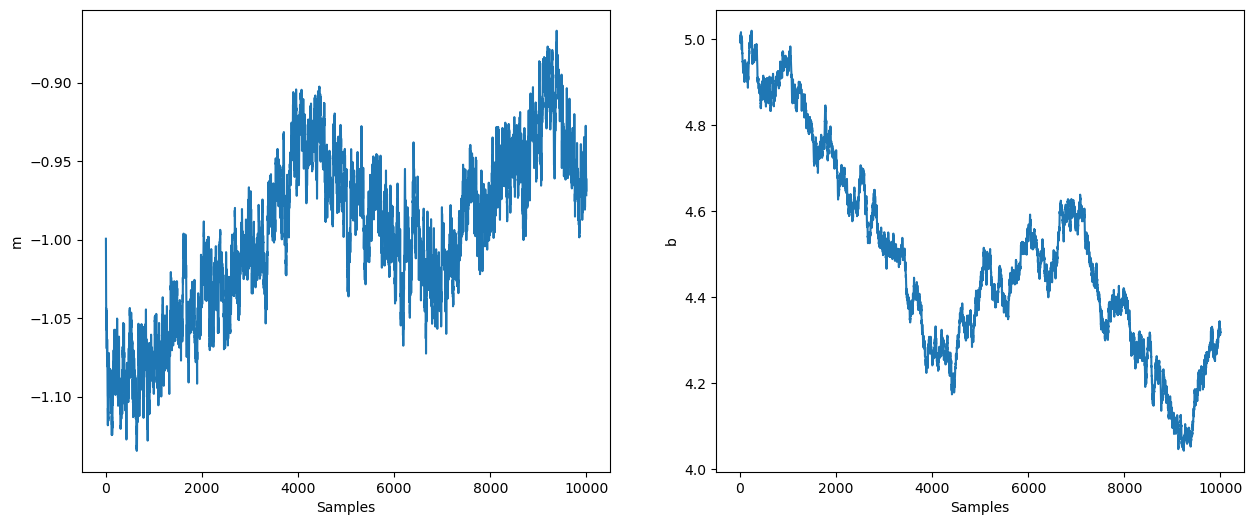

In [9]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(m_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("m")

ax1.plot(b_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("b")

In [10]:
inv_mass_matrix = np.array([0.01, 0.01, 0.01])
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [11]:
initial_position = {"m": -1.0, "b": 5.0, "log_f": jnp.log(0.5)}
initial_state = nuts.init(initial_position)
initial_state

<class 'jax._src.interpreters.ad.JVPTracer'>


HMCState(position={'m': -1.0, 'b': 5.0, 'log_f': Array(-0.6931472, dtype=float32, weak_type=True)}, logdensity=Array(-44.265114, dtype=float32), logdensity_grad={'b': Array(-79.052475, dtype=float32, weak_type=True), 'log_f': Array(5.0321994, dtype=float32, weak_type=True), 'm': Array(-402.75284, dtype=float32, weak_type=True)})

In [12]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, nuts.step, initial_state, 4_000)

m_samples = states.position["m"].block_until_ready()
b_samples = states.position["b"].block_until_ready()
#loc_samples = states.position["loc"].block_until_ready()
#scale_samples = jnp.exp(states.position["log_scale"])

<class 'jax._src.interpreters.ad.JVPTracer'>
CPU times: user 3.74 s, sys: 22.2 ms, total: 3.76 s
Wall time: 3.75 s


Text(0, 0.5, 'b')

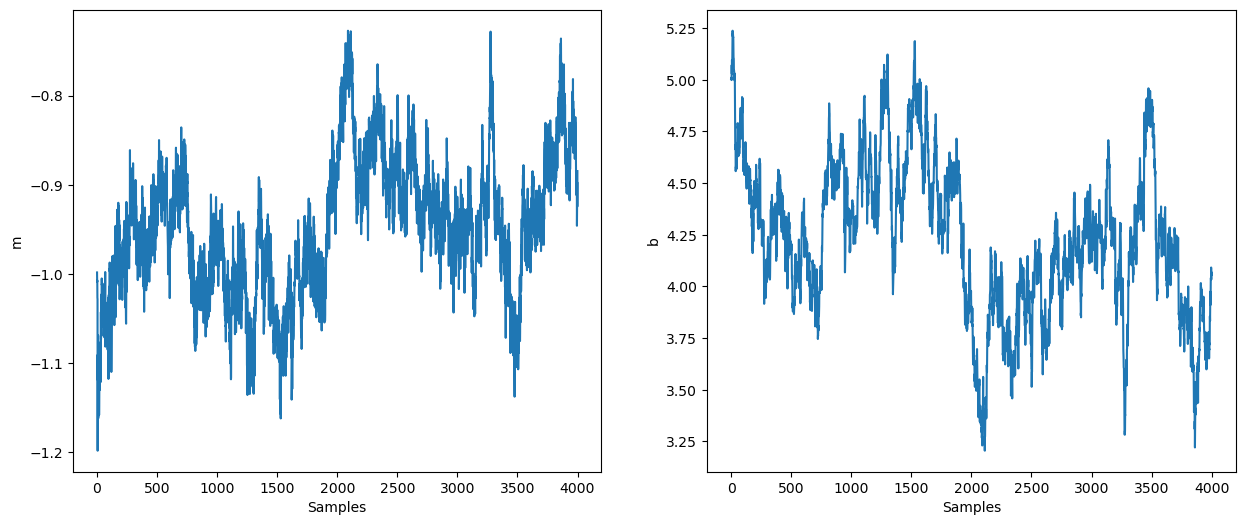

In [13]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(m_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("m")

ax1.plot(b_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("b")